In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
import sys
sys.path.append('/home/vaschetti/maxarSrc/datasets_and_samplers')
from myGeoDatasets import Maxar
from mySamplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import torch
from time import time

In [3]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
size = 608
sampler = MyGridGeoSampler(dataset, size=size, stride=size)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs

from build_seg_utils import building_gdf
gdfs_32628 = building_gdf('TheGambia', dataset_crs = data_crs)
index_MS_buildings = gdfs_32628.sindex

Found 6 links for TheGambia


In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
In plot
Crs EPSG:32628
sx_low:  (317998.046875, 1489843.75)
dx_high:  (318183.59375, 1490029.296875)


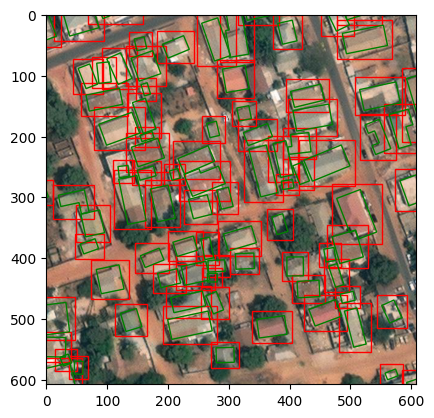

In [4]:
from random import randint
from build_seg_utils import rel_bbox_coords, rel_polyg_coord
dataset_res = dataset.res
i = 0
for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = index_MS_buildings.query(query_bbox_poly)
    if len(hits) > 10: #per prendere immagini con almeno X edifici
        i+=1
        if i == 10 :#randint(0, 20): #per prendere immagini random
            sample = unbind_samples(batch)[0]
            img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
            
            #predictor.set_image(img4Sam) #encoding the image

            #Getting the relative coordinates of the buildings boxes
            building_boxes = rel_bbox_coords(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res, ext_mt=5)

            #Plotting
            fig, ax = dataset.plot(sample)   
            for box in building_boxes:
                x0, y0 = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
                ax.add_patch(rect)
            for rel_pol in rel_polyg_coord(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res):
                poly = patches.Polygon(rel_pol, linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(poly)

            break

## SAM

In [5]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/vaschetti/maxarSrc/creating_labels/models/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda:0')

SAMpredictor = SamPredictor(sam)

In [6]:
t_0_Sam = time()
SAMpredictor.set_image(img4Sam)

#prepare the data for the model
building_boxes_t = torch.tensor(building_boxes, device=SAMpredictor.device)

#Given the box coorindates as xyxy return the center of the rectangle
point_coords = torch.tensor([[(sublist[0] + sublist[2])/2, (sublist[1] + sublist[3])/2] for sublist in building_boxes_t], device=SAMpredictor.device)
point_labels = torch.tensor([1] * point_coords.shape[0], device=SAMpredictor.device)
transformed_points = SAMpredictor.transform.apply_coords_torch(point_coords, img4Sam.shape[:2]).unsqueeze(1)
transformed_boxes = SAMpredictor.transform.apply_boxes_torch(building_boxes_t, img4Sam.shape[:2])

SAMmasks, _, _ = SAMpredictor.predict_torch(
                point_coords=None,
                point_labels=None,
                boxes=transformed_boxes,
                multimask_output=False,
            )
t_1_Sam = time() - t_0_Sam

## FastSAM

In [7]:
sys.path.append('/home/vaschetti/maxarSrc/creating_labels/models/')
from FastSAM.fastsam import FastSAM, FastSAMPrompt
from FastSAM.utils.tools import convert_box_xywh_to_xyxy

model_path = '/home/vaschetti/maxarSrc/creating_labels/models/FastSAM/weights/FastSAM-x.pt'
model = FastSAM(model_path)

In [8]:
device = 'cuda'
t_0_FastSam = time()
everything_results = model(
        img4Sam,
        device= device,
        imgsz=img4Sam.shape[0],
        )


0: 608x608 115 objects, 33.2ms
Speed: 5.4ms preprocess, 33.2ms inference, 40.3ms postprocess per image at shape (1, 3, 608, 608)


In [9]:
bboxes = None
points = None
point_label = None
prompt_process = FastSAMPrompt(img4Sam, everything_results, device=device)

box_prompt = building_boxes
if box_prompt[0][2] != 0 and box_prompt[0][3] != 0:
    FSAMmasks = prompt_process.box_prompt(bboxes=box_prompt)
    bboxes = box_prompt
t_1_FastSam = time() - t_0_FastSam

## Plotting Results

In [13]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='y', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='r', facecolor=(0,0,0,0), lw=0.5))

def plot_w_wo_masks_SAM(img, masks, boxes = None):
    
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    for mask in masks:
        show_mask(mask.cpu().numpy(), ax2)
    if boxes is not None:
        for box in boxes:
            show_box(box.cpu().numpy(), ax2)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

def plot_w_wo_masks_FSAM(img, masks, building_boxes = None):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    for mask in masks:
        show_mask(mask, ax2)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='y', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='r', facecolor=(0,0,0,0), lw=0.5))

def plot_w_wo_masks_SAM(img, masks, boxes = None):
    
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    for mask in masks:
        show_mask(mask.cpu().numpy(), ax2)
    if boxes is not None:
        for box in boxes:
            show_box(box.cpu().numpy(), ax2)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

def plot_w_wo_masks_FSAM(img, masks, building_boxes = None):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    for mask in masks:
        show_mask(mask, ax2)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

def SAMvsFSAM(img, SAM_masks, FSAM_masks, SAM_time = '', FastSAM_time = ''):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 3, 2)
    #img
    ax1.imshow(img)
    ax1.set_title('Original')

    #SAM
    ax2 = fig.add_subplot(1, 3, 1, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    for mask in SAM_masks:
        show_mask(mask.cpu().numpy(), ax2)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])
    ax2.set_title('SAM: ' + str(round(SAM_time, 2)) + ' (s)')


    #FastSAM
    ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)
    ax3.imshow(img)
    for mask in FSAM_masks:
        show_mask(mask, ax3)
    ax3.set_xlim([0, img.shape[1]])
    ax3.set_ylim([img.shape[0], 0])
    ax3.set_title('FastSAM: ' + str(round(FastSAM_time,2)) + ' (s)')

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')




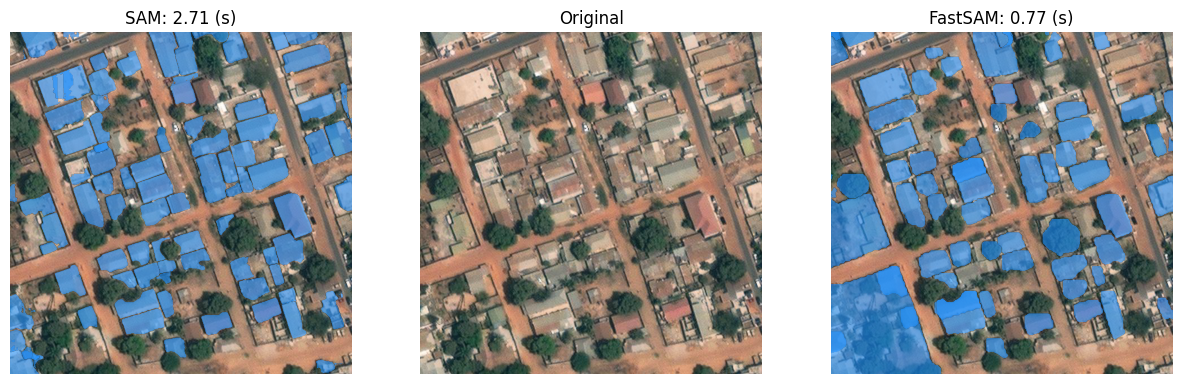

In [14]:
SAMvsFSAM(img4Sam, SAMmasks, FSAMmasks, SAM_time = t_1_Sam, FastSAM_time = t_1_FastSam)

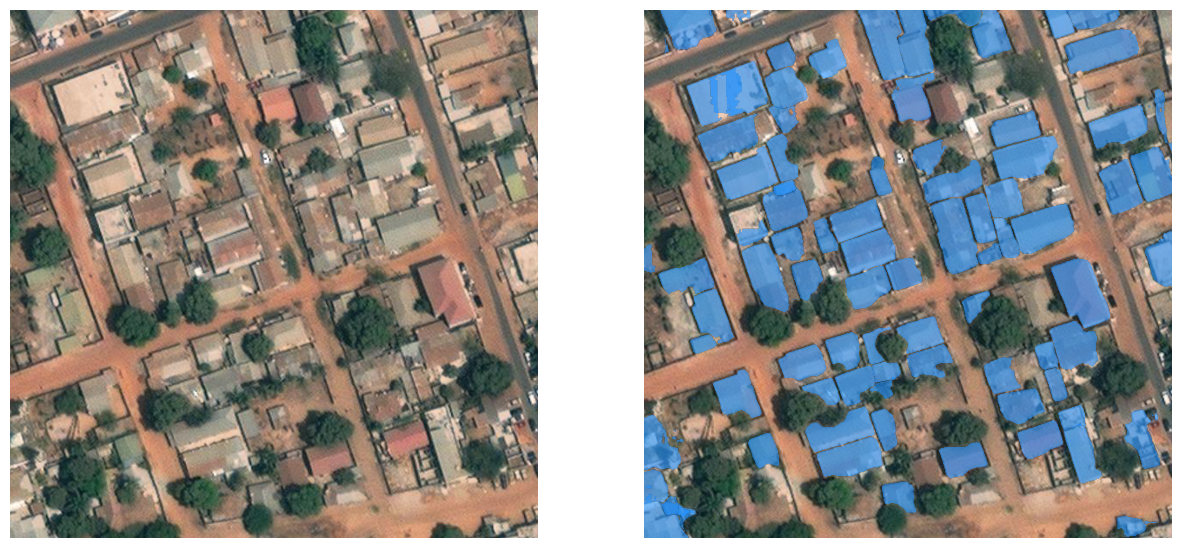

In [15]:
plot_w_wo_masks_SAM(img4Sam, SAMmasks)

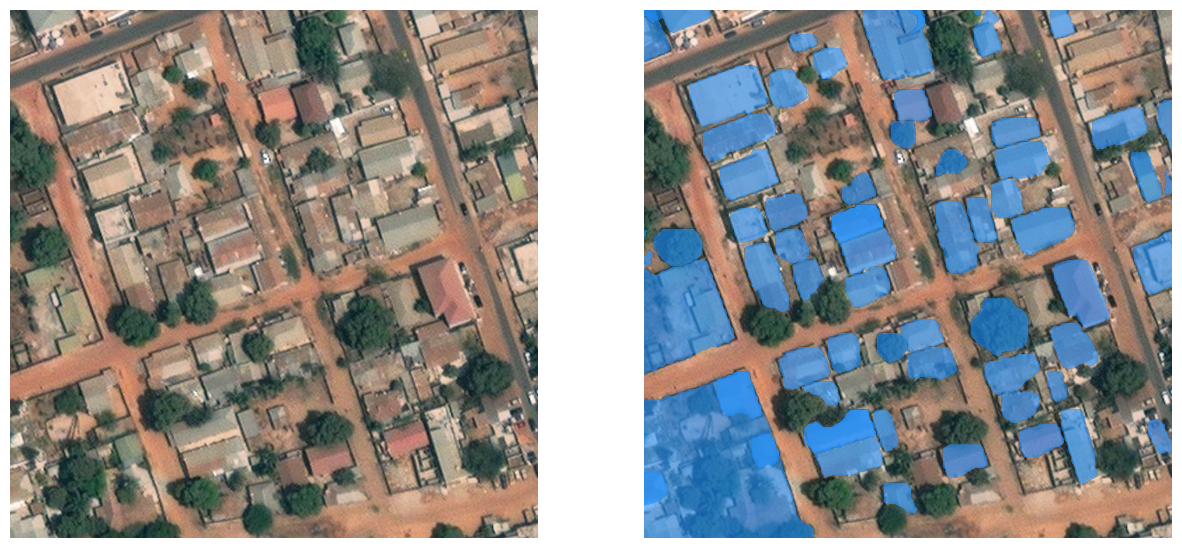

In [16]:
plot_w_wo_masks_FSAM(img4Sam, FSAMmasks)